In [2]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import torch
from torch import nn
from torchvision import models, transforms, datasets
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
from torchvision.models import VGG16_Weights


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #checking for gpu

reverse_genredict = {0:"blues", 1:"classical", 2:"country", 3:"disco", 4:"hiphop", 5:"jazz", 6:"metal", 7:"pop", 8:"reggae",9:"rock"}
genre_array = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#defining custom dataset to input to model
class MusicGenres(data.Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
    self.genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    name = str(self.annotations.iloc[index,0])
    y_label = self.genre_dict[str(self.annotations.iloc[index,59])]
    im = torch.load(self.root_dir+name+'.pt') #loading saved torch tensor representing file
    im = torch.unsqueeze(im,axis=0)  #adding 3rd dimension
    im = torch.tile(im,(3,1,1)) #repeating 2 dimensional array across 3 dimensions to resemble image input
    if self.transform:
      im = self.transform(im)

    return (im, y_label)

In [75]:
path_tensors = "drive/Shareddrives/DL Final Project/spectrogram_tensors/"
csv_file = 'drive/Shareddrives/DL Final Project/DL Final Project/features_3_sec.csv'
#splitting dataset into train and test
dataset = MusicGenres(csv_file = csv_file, root_dir = path_tensors)
length = len(dataset)
split = 0.15
test_size = int(length*split)
train_size = length - test_size
traindata, testdata = data.random_split(dataset, [train_size, test_size])

In [ ]:
class MusicClassifier(nn.Module):
  def __init__(self):
    super(MusicClassifier, self).__init__()
    self.sequential = nn.Sequential(
        nn.Conv2d(1,1,3),
        nn.Flatten(),
        nn.Linear(12032,1024),
        nn.Linear(1024,10),
        nn.Softmax()
    )
  
  def forward(self,x):
    probabilities = self.sequential(x)
    return probabilities

In [77]:
#saves model weights
def saveModel(model):
    path = "drive/Shareddrives/DL Final Project/DL Final Project/model.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(model, test_loader):

    model.to(device)  
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:

            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest probability will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return accuracy


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model, num_epochs, loss_fn, train_loader, test_loader, optimizer):
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):
        size = len(train_loader.dataset)

        for batch, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            
            pred = model(images)
            loss = loss_fn(pred, labels)

           # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
 
            loss, current = loss.item(), batch * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        accuracy = testAccuracy(model, test_loader)
        print('For epoch', epoch+1,'the test accuracy over the entire test set is %d %%' % (accuracy))
        

In [96]:
batch_size = 200
train_loader1 = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
                                          shuffle=True,num_workers=2)
test_loader1 = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=True,num_workers=2)

model1 = models.vgg16(weights=VGG16_Weights.DEFAULT)
num_filters = model1.classifier[-1].in_features
model1.classifier[-1] = nn.Linear(num_filters,10) #changes output of last dense layer in VGG-16 from ouputing 1000 classes to outputting 10

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001, weight_decay=0.0001)

#Note: First epoch takes much longer to run than subsequent epochs because data has to be loaded in
train(model = model1,num_epochs=15,train_loader = train_loader1, test_loader = test_loader1, loss_fn=loss_fn,optimizer=optimizer)
print('Finished Training')


The model will be running on cuda:0 device
loss: 8.808786  [    0/ 8483]
loss: 8.310627  [  200/ 8483]
loss: 3.234228  [  400/ 8483]
loss: 2.341087  [  600/ 8483]
loss: 2.884772  [  800/ 8483]
loss: 3.906440  [ 1000/ 8483]
loss: 2.587358  [ 1200/ 8483]
loss: 2.283644  [ 1400/ 8483]
loss: 3.540798  [ 1600/ 8483]
loss: 2.473015  [ 1800/ 8483]
loss: 2.331269  [ 2000/ 8483]
loss: 2.315682  [ 2200/ 8483]
loss: 2.340773  [ 2400/ 8483]
loss: 2.320840  [ 2600/ 8483]
loss: 2.329386  [ 2800/ 8483]
loss: 2.303628  [ 3000/ 8483]
loss: 2.608539  [ 3200/ 8483]
loss: 2.317037  [ 3400/ 8483]
loss: 2.401185  [ 3600/ 8483]
loss: 2.307696  [ 3800/ 8483]
loss: 2.302832  [ 4000/ 8483]
loss: 2.310713  [ 4200/ 8483]
loss: 2.420046  [ 4400/ 8483]
loss: 2.315283  [ 4600/ 8483]
loss: 2.301566  [ 4800/ 8483]
loss: 2.350875  [ 5000/ 8483]
loss: 2.317439  [ 5200/ 8483]
loss: 2.311622  [ 5400/ 8483]
loss: 2.311143  [ 5600/ 8483]
loss: 2.301203  [ 5800/ 8483]
loss: 2.304412  [ 6000/ 8483]
loss: 2.304353  [ 6200/ 848

Loading in weights of model that got 75% accuracy for us

In [83]:
model2 = models.vgg16(weights=VGG16_Weights.DEFAULT)
num_filters = model2.classifier[-1].in_features
model2.classifier[-1] = nn.Linear(num_filters,10)

modelpath = "drive/Shareddrives/DL Final Project/DL Final Project/model.pth"
model2.load_state_dict(torch.load(modelpath))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

the test accuracy over the entire test set is 78 %


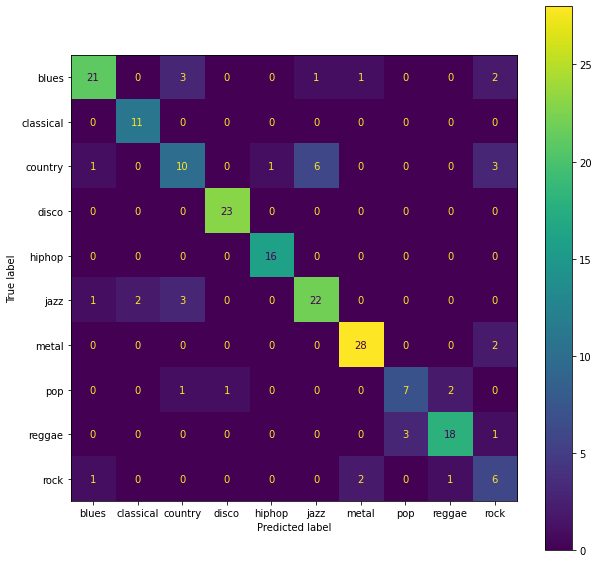

In [84]:
import sklearn.metrics
import matplotlib.pyplot as plt

accuracy = testAccuracy(model2,test_loader1)
print('the test accuracy over the entire test set is %d %%' % (accuracy))

with torch.no_grad():
  images,labels = next(iter(test_loader1))
  images = Variable(images.to(device))
  labels = Variable(labels.to(device))
  pred = model2(images)

_, predicted = torch.max(pred.data, 1)


predicted = [ reverse_genredict[k] for k in predicted.cpu().numpy() ]
labeldata = [ reverse_genredict[k] for k in labels.cpu().numpy() ]
matrix = sklearn.metrics.confusion_matrix(predicted,labeldata, labels = genre_array)
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix,display_labels = genre_array)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

